In [1]:
from pathlib import Path
import pandas as pd

import matplotlib.pyplot as plt
plt.rcParams['figure.dpi'] = 120
import seaborn as sns

import torch
import torch.nn as nn
import torch.functional as F

from netam import framework, models
from netam.common import pick_device, parameter_count_of_model

In [2]:
from netam.framework import load_shmoof_dataframes

shmoof_path = "/Users/matsen/data/shmoof_edges_11-Jan-2023_NoNode0_iqtree_K80+R_masked.csv"
val_nicknames = ['59', '88', '97', 'small']

site_count=500
batch_size=1024
device = pick_device()
# device = "cpu" # pick_device()

def data_of_nickname(nickname, kmer_length):
    train_df, val_df = load_shmoof_dataframes(shmoof_path, val_nickname=nickname) # , sample_count=1000)
    train_dataset = framework.SHMoofDataset(train_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset = framework.SHMoofDataset(val_df, kmer_length=kmer_length, site_count=site_count)
    val_dataset.nickname = nickname
    return train_dataset, val_dataset

Using Metal Performance Shaders


In [3]:
burrito_params = {
    "batch_size": 1024,
    "learning_rate": 0.1,
    "min_learning_rate": 1e-4,
    "l2_regularization_coeff": 1e-6
}
epochs = 100

In [4]:
def train_and_evaluate(model_name, model_instance, train_dataset, val_dataset):
    nickname = val_dataset.nickname
    save_dir = f"_ignore/model_comparison_pretrained/{nickname}"
    crepe_path = f"{save_dir}/{model_name}"
    train_dataset.to(device)
    val_dataset.to(device)
    if framework.crepe_exists(crepe_path):
        crepe = framework.load_crepe(crepe_path)
        print(f"\tLoaded {model_name}...", end="\t")
        
        model_instance = crepe.model
        model_instance.to(device) 
        burrito = framework.SHMBurrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
        epochs_used = 0
    else:
        print(f"\tTraining {model_name}...", end="\t")
        model_instance.to(device)
        burrito = framework.SHMBurrito(train_dataset, val_dataset, model_instance, verbose=False, **burrito_params)
    
        train_history = burrito.multi_train(epochs=epochs, max_tries=3)
        Path(save_dir).mkdir(parents=True, exist_ok=True)
        burrito.save_crepe(crepe_path)
        epochs_used = len(train_history)
        

    val_loss = burrito.evaluate()
    print(f"val loss: {val_loss}")
    result = {'model_name': model_name, 'model': str(model_instance), 'parameter_count': parameter_count_of_model(model_instance), 'val_loss': val_loss, 'epochs_used': epochs_used}
    return result

def comparison_of_data(model_instances, train_dataset, val_dataset):
    results_list = []

    for model_name, model_instance in model_instances.items():
        result = train_and_evaluate(model_name, model_instance, train_dataset, val_dataset)
        results_list.append(result)

    results_df = pd.DataFrame(results_list)
    return results_df

comparison_dfs = []
for nickname in val_nicknames:
    print(f"Val nickname is {nickname}")
    # train_dataset_1, val_dataset_1 = data_of_nickname(nickname, kmer_length=1)
    train_dataset_3, val_dataset_3 = data_of_nickname(nickname, kmer_length=3)
    train_dataset_5, val_dataset_5 = data_of_nickname(nickname, kmer_length=5)
    
    model_instances_1 = {
        # _ignore/optuna_CNN1merModel_20231125_071248.csv
        # Best Hyperparameters: {'kernel_size': 11, 'dropout': 0.2, 'num_filters': 17}
        # "cnn_1mer": models.CNN1merModel(train_dataset_1, num_filters=17, kernel_size=11, dropout_prob=0.2)
    }
    
    burrito_params["l2_regularization_coeff"] = 1e-5
    model_instances_3 = {
        "cnn_8k": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_prob=0.0),
        "cnn_8k_drp01": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_prob=0.1),
        "cnn_8k_drp02": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_prob=0.2),
        "cnn_8k_drp03": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_prob=0.3),
        "cnn_8k_drp04": models.CNNModel(kmer_length=3, embedding_dim=14, filter_count=25, kernel_size=15, dropout_prob=0.4),
    }

    model_instances_5 = {
        "fivemer": models.FivemerModel(kmer_length=5),
        "shmoof": models.SHMoofModel(kmer_length=5, site_count=site_count),
    }
     
    comparison_df = \
        pd.concat([# comparison_of_data(model_instances_1, train_dataset_1, val_dataset_1),
                   comparison_of_data(model_instances_3, train_dataset_3, val_dataset_3),
                   comparison_of_data(model_instances_5, train_dataset_5, val_dataset_5)
                ])
    comparison_df["val_nickname"] = nickname

    # make val_nickname the first column
    cols = comparison_df.columns.tolist()
    cols = cols[-1:] + cols[:-1]
    comparison_df = comparison_df[cols]

    comparison_dfs.append(comparison_df)

final_df = pd.concat(comparison_dfs)
final_df.to_csv(f"_ignore/model_comparison_{framework.timestamp_str()}.csv", index=False)
final_df
    

Val nickname is 59
	Loaded cnn_8k...	val loss: 0.05824618500379533
	Loaded cnn_8k_drp01...	val loss: 0.05889632918077354
	Loaded cnn_8k_drp02...	val loss: 0.05828802646751898
	Loaded cnn_8k_drp03...	val loss: 0.05782955605576449
	Loaded cnn_8k_drp04...	val loss: 0.0610303391872997
	Loaded fivemer...	val loss: 0.05823207300472758
	Loaded shmoof...	val loss: 0.0581089423502733
Val nickname is 88
	Training cnn_8k...	

Epoch:  64%|██████▍   | 64/100 [11:02<06:12, 10.36s/it, loss_diff=1.836e-06, lr=3.2e-5, val_loss=0.05069]  


val loss: 0.050655161395285156
	Loaded cnn_8k_drp01...	val loss: 0.05060273997381179
	Loaded cnn_8k_drp02...	val loss: 0.050764086935335156
	Training cnn_8k_drp03...	

Epoch:  31%|███       | 31/100 [05:39<12:36, 10.96s/it, loss_diff=-2.861e-06, lr=3.2e-5, val_loss=0.05045] 


val loss: 0.05041147445647072
	Training cnn_8k_drp04...	

Epoch: 100%|██████████| 100/100 [16:29<00:00,  9.90s/it, loss_diff=-3.9e-07, lr=3.2e-5, val_loss=0.05045]  


val loss: 0.050435618597335134
	Loaded fivemer...	val loss: 0.05071599011555105
	Loaded shmoof...	val loss: 0.05065938821994679
Val nickname is 97
	Training cnn_8k...	

Epoch:  70%|███████   | 70/100 [13:41<05:52, 11.74s/it, loss_diff=2.839e-07, lr=3.2e-5, val_loss=0.05469]  


val loss: 0.0546939422030745
	Training cnn_8k_drp01...	

Epoch: 100%|██████████| 100/100 [14:45<00:00,  8.85s/it, loss_diff=-2.169e-05, lr=0.1, val_loss=0.05547]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch:  42%|████▏     | 42/100 [07:59<11:01, 11.41s/it, loss_diff=1.156e-06, lr=3.2e-5, val_loss=0.05449]  


val loss: 0.05448106666497857
	Training cnn_8k_drp02...	

Epoch: 100%|██████████| 100/100 [16:50<00:00, 10.11s/it, loss_diff=-1.798e-05, lr=0.1, val_loss=0.0558]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [17:31<00:00, 10.52s/it, loss_diff=9.906e-06, lr=0.02, val_loss=0.05513]


Learning rate 0.020000000000000004 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [16:56<00:00, 10.16s/it, loss_diff=-3.235e-06, lr=0.1, val_loss=0.0559]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.
Failed to train model to min_learning_rate after 3 tries.
val loss: 0.06206719117187446
	Training cnn_8k_drp03...	

Epoch: 100%|██████████| 100/100 [17:40<00:00, 10.60s/it, loss_diff=-4.572e-05, lr=0.1, val_loss=0.05562]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [17:46<00:00, 10.66s/it, loss_diff=-8.021e-06, lr=0.004, val_loss=0.05509]


Learning rate 0.004000000000000001 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [18:21<00:00, 11.02s/it, loss_diff=-2.353e-05, lr=0.1, val_loss=0.05529]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.
Failed to train model to min_learning_rate after 3 tries.
val loss: 0.06228646040553303
	Training cnn_8k_drp04...	

Epoch: 100%|██████████| 100/100 [16:30<00:00,  9.90s/it, loss_diff=6.859e-06, lr=0.0008, val_loss=0.05586]


Learning rate 0.0008000000000000003 not below 0.0001. Resetting model and optimizer.


Epoch:  54%|█████▍    | 54/100 [09:13<07:51, 10.25s/it, loss_diff=-2.109e-06, lr=3.2e-5, val_loss=0.05679] 


val loss: 0.05668014640793145
	Loaded fivemer...	val loss: 0.055357371130896685
	Loaded shmoof...	val loss: 0.05483248976983199
Val nickname is small
	Training cnn_8k...	

Epoch:  95%|█████████▌| 95/100 [12:30<00:39,  7.90s/it, loss_diff=0, lr=3.2e-5, val_loss=0.05754]          


val loss: 0.05753955658702623
	Training cnn_8k_drp01...	

Epoch: 100%|██████████| 100/100 [18:39<00:00, 11.20s/it, loss_diff=-2.541e-05, lr=0.1, val_loss=0.0563]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [18:50<00:00, 11.30s/it, loss_diff=-2.406e-05, lr=0.1, val_loss=0.05559]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch: 100%|██████████| 100/100 [18:37<00:00, 11.18s/it, loss_diff=-2.194e-05, lr=0.1, val_loss=0.05584]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.
Failed to train model to min_learning_rate after 3 tries.
val loss: 0.06924700431596666
	Training cnn_8k_drp02...	

Epoch: 100%|██████████| 100/100 [13:52<00:00,  8.33s/it, loss_diff=-1.656e-05, lr=0.1, val_loss=0.05723]


Learning rate 0.1 not below 0.0001. Resetting model and optimizer.


Epoch:  43%|████▎     | 43/100 [08:00<10:36, 11.17s/it, loss_diff=-3.303e-06, lr=3.2e-5, val_loss=0.05536] 


val loss: 0.05533008456230164
	Training cnn_8k_drp03...	

Epoch:  89%|████████▉ | 89/100 [16:42<02:03, 11.26s/it, loss_diff=7.152e-07, lr=3.2e-5, val_loss=0.05567]  


val loss: 0.05565783927979923
	Training cnn_8k_drp04...	

Epoch:  47%|████▋     | 47/100 [08:28<09:33, 10.82s/it, loss_diff=-2.398e-06, lr=3.2e-5, val_loss=0.05548] 


val loss: 0.05545227101019451
	Loaded fivemer...	val loss: 0.055735408995832715
	Loaded shmoof...	val loss: 0.05559203134264265


,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058246,0
1,59,cnn_8k_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058896,0
2,59,cnn_8k_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058288,0
3,59,cnn_8k_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.057830,0
4,59,cnn_8k_drp04,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.061030,0
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058232,0
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.058109,0
0,88,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050655,65
1,88,cnn_8k_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050603,0
2,88,cnn_8k_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050764,0


/var/folders/16/pkph6n2962g3lf2wpwwt0wwr0000gn/T/ipykernel_90545/2153285373.py:33: UserWarning: set_ticklabels() should only be used with a fixed number of ticks, i.e. after set_ticks() or using a FixedLocator.
  ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")


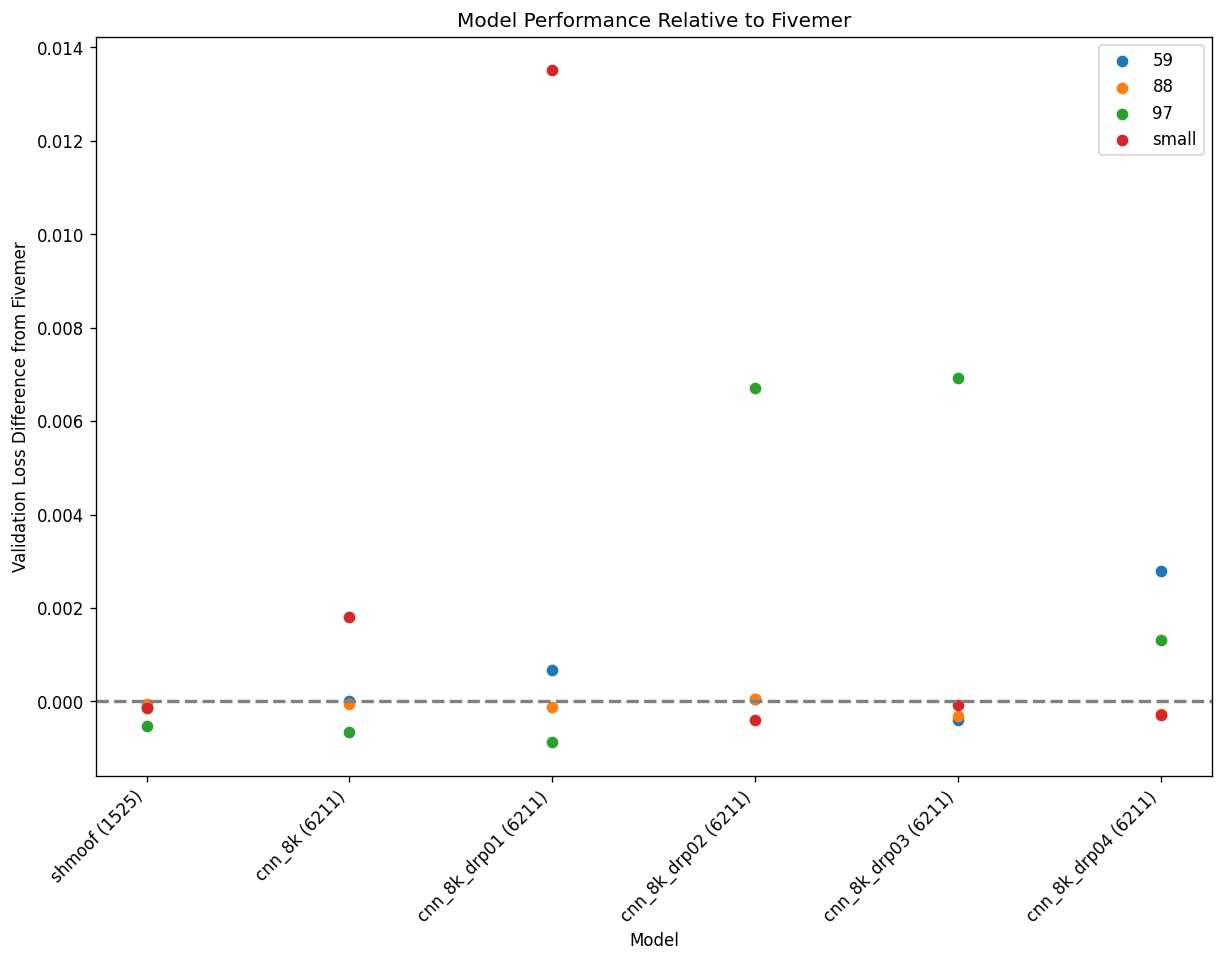

In [5]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df 

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
model_to_xlabel_str = {}
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model_name'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            model_label = f"{row['model_name']} ({row['parameter_count']})"
            model_to_xlabel_str[row['model_name']] = model_label
            loss_diffs.append({'val_nickname': nickname, 'model_name': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame and sort by parameter count
loss_diff_df = pd.DataFrame(loss_diffs)
# sort first by parameter count then by model name
loss_diff_df = loss_diff_df.sort_values(by=['parameter_count', 'model_name'])

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['model_name'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Model')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.set_xticklabels(subset['model_name'].map(model_to_xlabel_str), rotation=45, ha="right")
ax.legend()
plt.show()


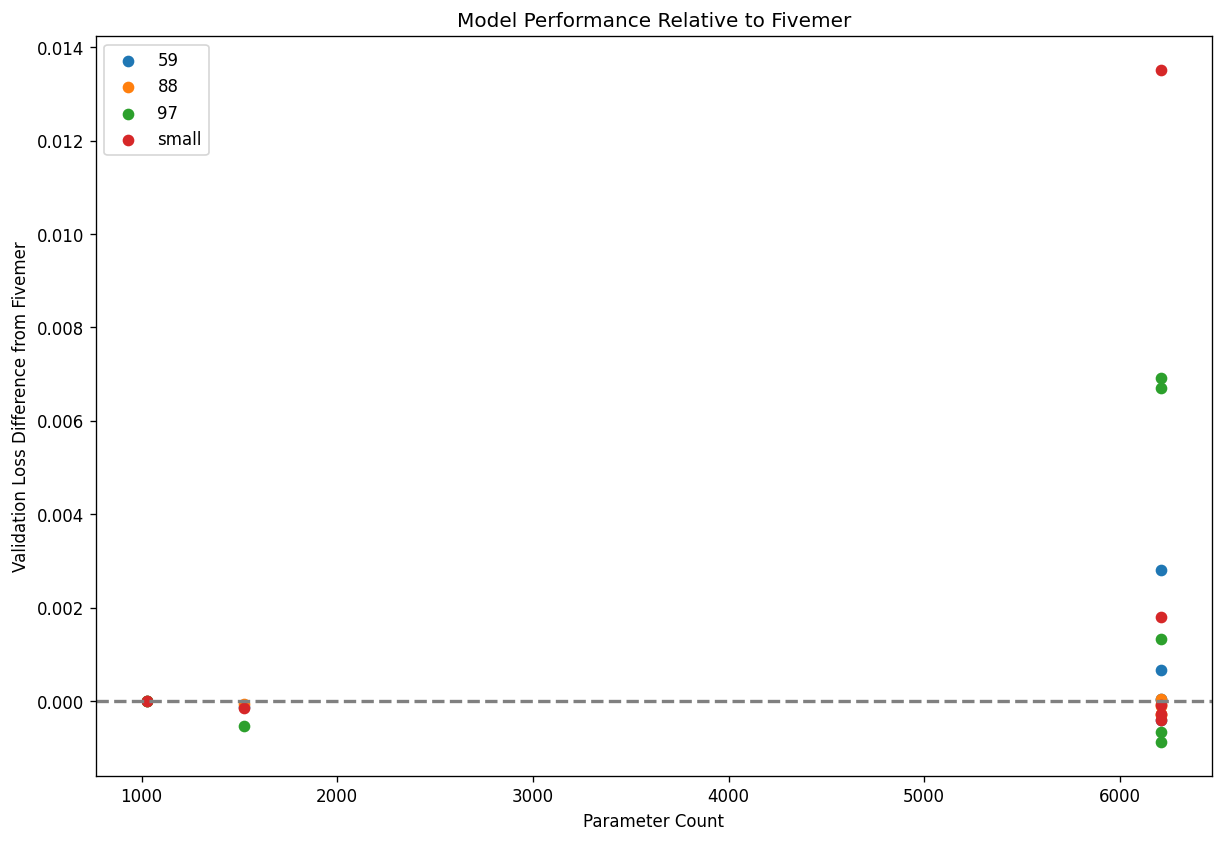

In [6]:
import pandas as pd
import matplotlib.pyplot as plt

df = final_df

# Calculate the difference in validation loss from the fivemer model
loss_diffs = []
for nickname in df['val_nickname'].unique():
    fivemer_loss = df[(df['model_name'] == 'fivemer') & (df['val_nickname'] == nickname)]['val_loss'].values[0]
    for _, row in df[df['val_nickname'] == nickname].iterrows():
        if row['model'] != 'fivemer':
            diff = row['val_loss'] - fivemer_loss
            loss_diffs.append({'val_nickname': nickname, 'model': row['model_name'], 'parameter_count': row['parameter_count'], 'loss_diff': diff})

# Convert to DataFrame
loss_diff_df = pd.DataFrame(loss_diffs)

# Plotting
fig, ax = plt.subplots(figsize=(12, 8))
for nickname in loss_diff_df['val_nickname'].unique():
    subset = loss_diff_df[loss_diff_df['val_nickname'] == nickname]
    ax.scatter(subset['parameter_count'], subset['loss_diff'], label=nickname)

ax.set_xlabel('Parameter Count')
ax.set_ylabel('Validation Loss Difference from Fivemer')
ax.set_title('Model Performance Relative to Fivemer')
ax.axhline(0, color='grey', lw=2, linestyle='--')
ax.legend()
plt.show()


In [7]:
final_df

,val_nickname,model_name,model,parameter_count,val_loss,epochs_used
0,59,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058246,0
1,59,cnn_8k_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058896,0
2,59,cnn_8k_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.058288,0
3,59,cnn_8k_drp03,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.057830,0
4,59,cnn_8k_drp04,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.061030,0
0,59,fivemer,FivemerModel(\n (kmer_embedding): Embedding(1...,1025,0.058232,0
1,59,shmoof,SHMoofModel(\n (kmer_embedding): Embedding(10...,1525,0.058109,0
0,88,cnn_8k,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050655,65
1,88,cnn_8k_drp01,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050603,0
2,88,cnn_8k_drp02,"CNNModel(\n (kmer_embedding): Embedding(65, 1...",6211,0.050764,0
